### Setup

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from time import sleep
from geopy.distance import geodesic
import matplotlib.gridspec as gridspec
from scipy.stats import norm

import matplotlib.pylab as plt
from scipy.stats import multivariate_normal

import random

In [2]:
def confidence_ellipse(loc, cov, n_std=3, **kwargs):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    std_devs = np.sqrt(eigenvalues) * n_std

    t = np.linspace(0, 2*np.pi, 100)
    x = std_devs[0] * np.cos(t)
    y = std_devs[1] * np.sin(t)

    x_rotated = x * np.cos(angle) - y * np.sin(angle) + loc[0]
    y_rotated = x * np.sin(angle) + y * np.cos(angle) + loc[1]

    points = np.array([x_rotated, y_rotated]).T
    return go.Scattermapbox(
        lon=points[:, 1],
        lat=points[:, 0],
        **kwargs,
        mode='lines',
    )

In [3]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

## Kalman filter project

#### Loading data

In [4]:
fn = 'kf_log.txt'
df = np.genfromtxt(fn, delimiter=',', usecols=(0, 1, 2))[6:]

df_x = []

i = 0
iss = []

while i < len(df):
    df_x.append(df[i])
    i += random.randint(1, 7)
    iss.append(i)

df = np.array(df_x)

Picking random points from the dataframe to simulate random time delta.

In [5]:
fn = 'kf_log.txt'
dff = np.genfromtxt(fn, delimiter=',', usecols=(0))

td = []
for i in range(0, len(iss) - 3):
    td.append(dff[iss[i+1]]-dff[iss[i]])

print(f"td mean: {np.mean(td):.3f}, td var: {np.var(td):.3f}")

td mean: 4.114, td var: 4.468


In [6]:
df[:4]

array([[ 4.25499904, 50.43911311, 15.3631169 ],
       [ 5.82338798, 50.43913394, 15.36311262],
       [ 7.79837263, 50.43916897, 15.36313425],
       [10.79725397, 50.43920757, 15.36316535]])

### CVM

$$
\begin{aligned}
x_{1,t} &= x_{1,t-1} + r_{x_1,t}\Delta_t + v_{x_{1},t}, \\
x_{2,t} &= x_{2,t-1} + r_{x_2,t}\Delta_t + v_{x_{2},t}, \\
r_{x_1,t} &= r_{x_1,t-1} + v_{r_{x_1},t} \\
r_{x_2,t} &= r_{x_2,t-1} + v_{r_{x_2},t} \\
\end{aligned}
$$

Notation using matrices:
$$
\underbrace{
\begin{bmatrix}
x_{1,t} \\
x_{2,t} \\
r_{x_1,t} \\
r_{x_2,t}
\end{bmatrix}
}_{x_t}
=
\underbrace{
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
}_{A_t}
\underbrace{
\begin{bmatrix}
x_{1,t-1} \\
x_{2,t-1} \\
r_{x_1,t-1} \\
r_{x_2,t-1}
\end{bmatrix}
}_{x_{t-1}}
+
\underbrace{
\begin{bmatrix}
v_{x_1,t} \\
v_{x_2,t} \\
v_{r_{x_1},t} \\
v_{r_{x_2},t}
\end{bmatrix}
}_{v_t}.
$$

###

### Kalman filter

$$
\begin{alignat}{2}
X_t &\sim \mathcal{N}(Ax_{t-1}, Q) &&\qquad\text{w/ density}\quad p(x_t|x_{t-1}) \\
Z_t &\sim \mathcal{N}(Hx_{t}, R) &&\qquad\text{w/ density}\quad f(z_t|x_t).
\end{alignat}
$$

$$
\pi(x_t|z_{0:t-1}) \equiv \mathcal{N}(\hat{x}_{t-1|t-1}, P_{t-1|t-1}).
$$

#### Prediction

$$
\begin{aligned}
\pi(x_{t}|z_{0:t-1})
&= \int p(x_{t}|x_{t-1})\, \pi(x_{t-1}|z_{0:t-1})\, \mathrm{d}x_{t-1} \\
&= \int \pi(x_t, x_{t-1}|z_{0:t-1}) \mathrm{d}x_{t-1}.
\end{aligned}
$$

$$
\begin{aligned}
    \hat{x}_{t|t-1} &= A \hat{x}_{t-1|t-1}, \\
    P_{t|t-1} &= A P_{t-1|t-1} A^{\intercal} + Q.
\end{aligned}
$$

#### Update

$$
\pi(x_{t}|z_{0:t})
= \frac{f(z_{t}|x_{t})\, \pi(x_{t}|z_{0:t-1})}{\int f(z_{t}|x_{t})\, \pi(x_{t}|z_{0:t-1}) dx_t}
\propto
f(z_{t}|x_{t})\,
\pi(x_{t}|z_{0:t-1}).
$$

#### Final equations

$$
\begin{aligned}
\hat{x}_{t|t-1} &= A \hat{x}_{t-1|t-1}, \qquad &&\text{(predicted state estimate)} \\
P_{t|t-1} &= A P_{t-1|t-1} A^{\intercal} + Q, \qquad &&\text{(predicted error covariance)} \\
\\
\hat{z}_{t|t-1} &= H \hat{x}_{t|t-1}, \qquad &&\text{(prediction)} \\
\nu_t &= z_t - \hat{z}_{t|t-1}, \qquad &&\text{(innovation residual)} \\
S_t &= H P_{t|t-1} H^\intercal + R, \qquad &&\text{(innovation covariance)} \\
W_t &= P_{t|t-1} H^\intercal S_t^{-1}, \qquad &&\text{(optimal kalman gain)} \\
\hat{x}_{t|t} &= \hat{x}_{t|t-1} + W_t \nu_t, \qquad &&\text{(corrected (a posteriori) state estimate $x_t$)} \\
P_{t|t} &= (I - W_t H) P_{t|t-1}. \qquad &&\text{(corrected (a posteriori) estimate covariance)}
\end{aligned}
$$

##
<div style="text-align: center">
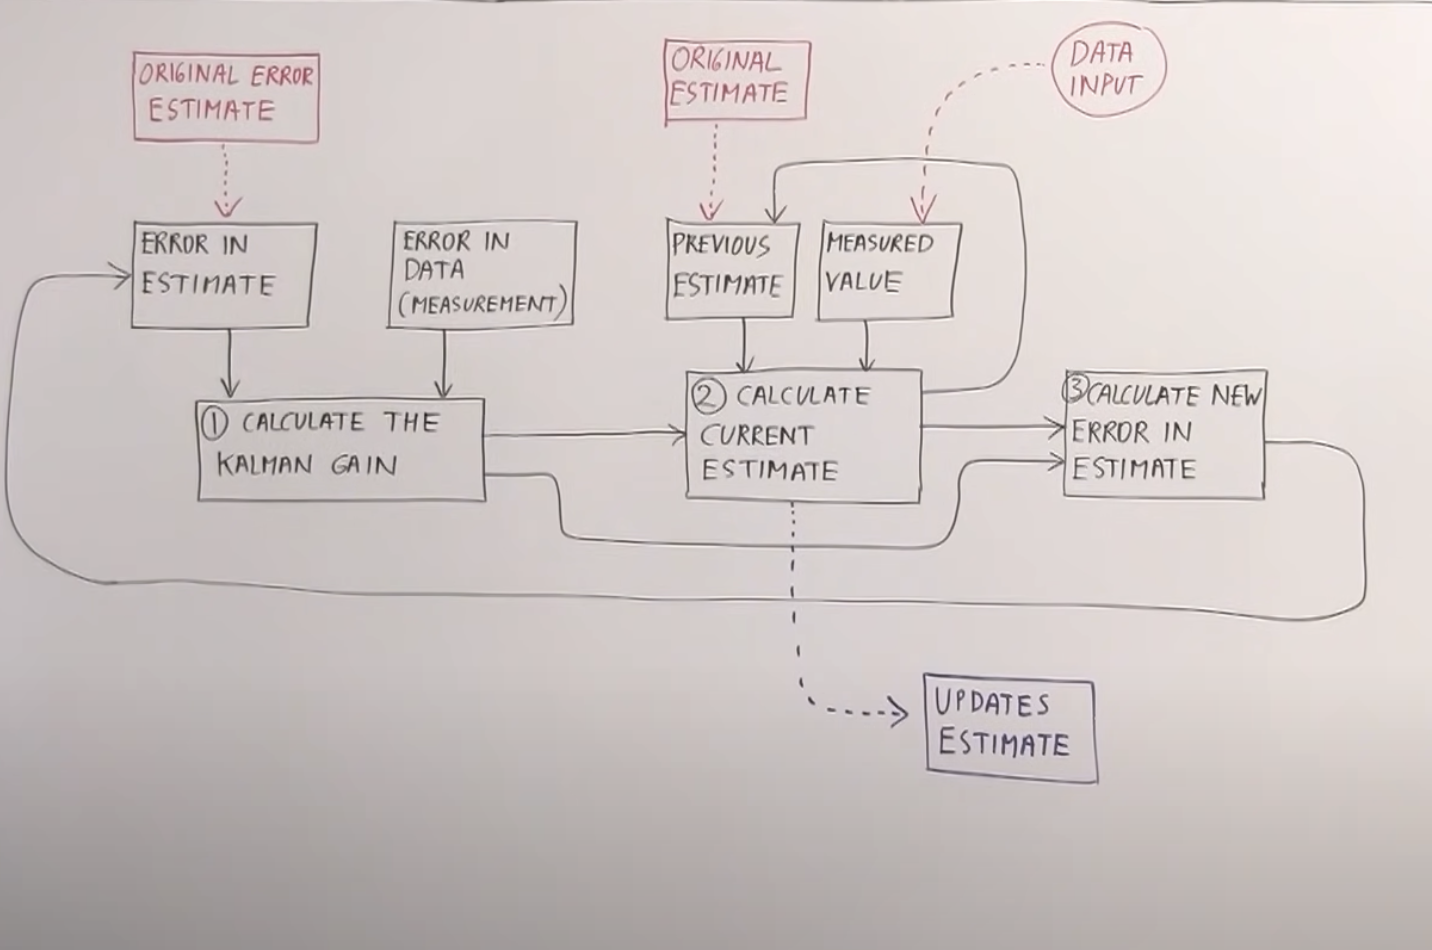
</div>

##
#### Dimensions
$$
\begin{aligned}
x : 4 \times 1\\
A : 4 \times 4\\
H : 2 \times 4\\
P : 4 \times 4\\
Q : 4 \times 4\\
S : 2 \times 2\\
R : 2 \times 2\\
W : 4 \times 2\\
v : 2 \times 1\\
z : 2 \times 1\\
\end{aligned}
$$

## Implementation 
#### Variable initialization

In [7]:
dt = 2 # one measurement
min_dt = 2 # predict every max 2 seconds
last_prediction = 4 # time of the last prediction
max_measurement = np.max(df[:, 0]) # time of the last measurement

H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) # to select out the coordinates
A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1,  0], [0, 0, 0,  1]]) # see the CVM section above

R = 1.5 * np.array([[ 1.81191102e-10, 0], [0,  1.51895672e-09]]) # Sensor noise covariance matrix

q =  1.5e-5
Q = (q**2) * np.array([[(dt**3)/3, 0, (dt**2)/2, 0],[0, (dt**3)/3, 0, (dt**2)/2],[(dt**2)/2, 0, dt, 0],[0, (dt**2)/2, 0, dt]]) # process noise covariance

x_est = [] # predicted state estimates
v = [] # innovation residuals
P_est = [] # predicted error covariances 
W = [] # optimal kalman gain
S = [] # innovation covariance

P_corr = [np.eye(4)] # corrected error covariances
x_corr = [np.array([df[0, 1], df[0, 2], 0, 0])] # corrected state estimates

In [8]:
lat_sd = Q[0,0] ** (1/2)
print(f"Three latitude sds: {3 * lat_sd}")

Three latitude sds: 7.348469228349534e-05


In [9]:
print(f"Which corresponds to a distance of {calculate_distance(0, 0, 0, 3 * lat_sd):.3f} m")

Which corresponds to a distance of 8.180 m


#### Algorithm

In [10]:
max_measurement

382.7913803

In [11]:
i = 0
corr_t = 1
pred_t = 0
last_predicted = False


while (i < len(df)):
    
    if (df[i, 0] - last_prediction) > min_dt:

        last_prediction += min_dt

        if not last_predicted:
            dt = min_dt
            A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1,  0], [0, 0, 0,  1]])
            Q = (q**2) * np.array([[(dt**3)/3, 0, (dt**2)/2, 0],[0, (dt**3)/3, 0, (dt**2)/2],[(dt**2)/2, 0, dt, 0],[0, (dt**2)/2, 0, dt]])
            x_pred = A @ x_corr[corr_t-1]
            P_pred = A @ P_corr[corr_t-1] @ A.T + Q
            last_predicted = True
        else:
            x_pred = A @ x_est[pred_t - 1]
            P_pred = A @ P_est[pred_t - 1] @ A.T + Q

        x_est.append(x_pred)
        P_est.append(P_pred)
        pred_t += 1

    else:
        dt = df[i, 0] - last_prediction
        last_prediction = df[i, 0]
        zt = df[i, 1:3]

        A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1,  0], [0, 0, 0,  1]])
        Q = (q**2) * np.array([[(dt**3)/3, 0, (dt**2)/2, 0],[0, (dt**3)/3, 0, (dt**2)/2],[(dt**2)/2, 0, dt, 0],[0, (dt**2)/2, 0, dt]])

        i += 1 

        # predict
        if last_predicted:
            x_pred = A @ x_est[pred_t - 1]
            P_pred = A @ P_est[pred_t - 1] @ A.T + Q
        else:
            x_pred = A @ x_corr[corr_t-1]
            P_pred = A @ P_corr[corr_t-1] @ A.T + Q
        z_pred = H @ x_pred
        
        #update
        vt = zt - z_pred
        St = H @ P_pred @ H.T + R
        Wt = P_pred @ H.T @ np.linalg.inv(St)
        x_pred_corr = x_pred + Wt @ vt
        P_pred_corr =  (np.eye(4) - Wt @ H) @ P_pred

        last_predicted = False
        corr_t += 1
        pred_t += 1
        
        x_est.append(x_pred)
        P_est.append(P_pred)
        v.append(vt)
        W.append(Wt)
        S.append(St)
        x_corr.append(x_pred_corr)
        P_corr.append(P_pred_corr)

#### Kalman gain progression

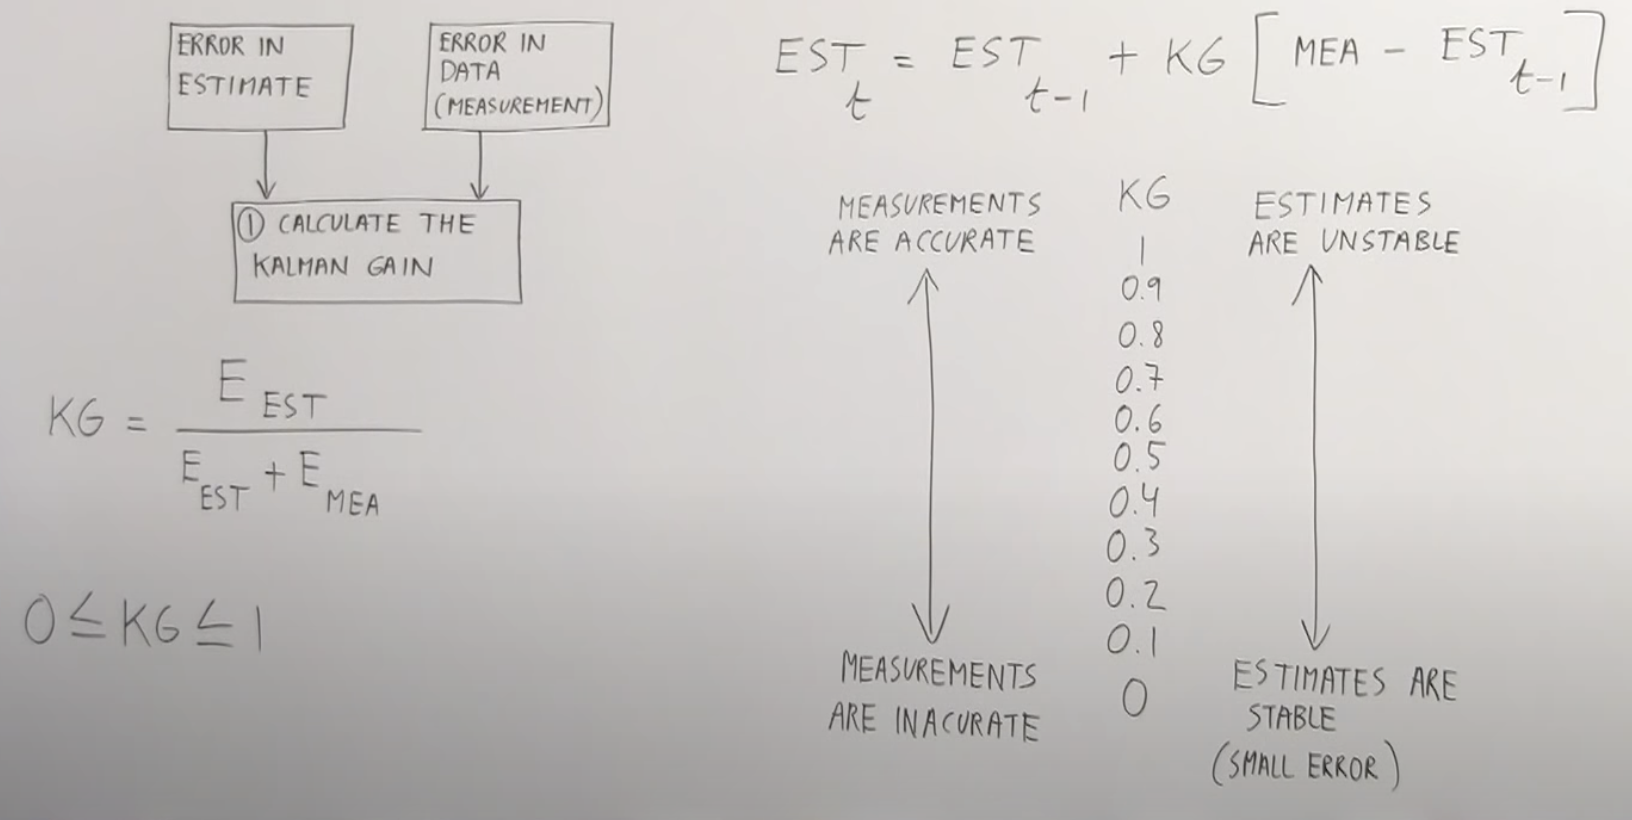

In [12]:
print("First 5 KG matrices:")
display(W[:5])

print("\nLast 3 KG matrices")
W[-3:]

First 5 KG matrices:


[array([[1.        , 0.        ],
        [0.        , 1.        ],
        [0.23943021, 0.        ],
        [0.        , 0.23943021]]),
 array([[1.        , 0.        ],
        [0.        , 1.        ],
        [0.63759695, 0.        ],
        [0.        , 0.63759695]]),
 array([[0.91307257, 0.        ],
        [0.        , 0.87722283],
        [0.40966289, 0.        ],
        [0.        , 0.31160046]]),
 array([[0.95087998, 0.        ],
        [0.        , 0.85820005],
        [0.34295087, 0.        ],
        [0.        , 0.2214985 ]]),
 array([[0.97432112, 0.        ],
        [0.        , 0.89173996],
        [0.28539723, 0.        ],
        [0.        , 0.20428209]])]


Last 3 KG matrices


[array([[0.7554866 , 0.        ],
        [0.        , 0.61064761],
        [0.48951785, 0.        ],
        [0.        , 0.18218883]]),
 array([[0.97643972, 0.        ],
        [0.        , 0.89001281],
        [0.28013992, 0.        ],
        [0.        , 0.2146389 ]]),
 array([[0.99067516, 0.        ],
        [0.        , 0.94879746],
        [0.20730097, 0.        ],
        [0.        , 0.16988649]])]

#### Highest change in latitude and longitude variance

In [13]:
max_val = -9999
min_val = 9999
max_index = 0
min_index = 0

for i, matrix in enumerate(P_corr[3:]):
    combined_value = matrix[0, 0]
    if combined_value > max_val:
        max_val = combined_value
        max_index = i
    if combined_value < min_val:
        min_val = combined_value
        min_index = i

print("Highest - lowest latitude variance: ", max_val - min_val)

max_val = -9999
min_val = 9999
max_index = 0
min_index = 0

for i, matrix in enumerate(P_corr[3:]):
    combined_value = matrix[1, 1]
    if combined_value > max_val:
        max_val = combined_value
        max_index = i
    if combined_value < min_val:
        min_val = combined_value
        min_index = i

print("Highest - lowest longitude variance: ", max_val - min_val)

Highest - lowest latitude variance:  6.658432642535384e-11
Highest - lowest longitude variance:  9.244949733800968e-10


### On a map

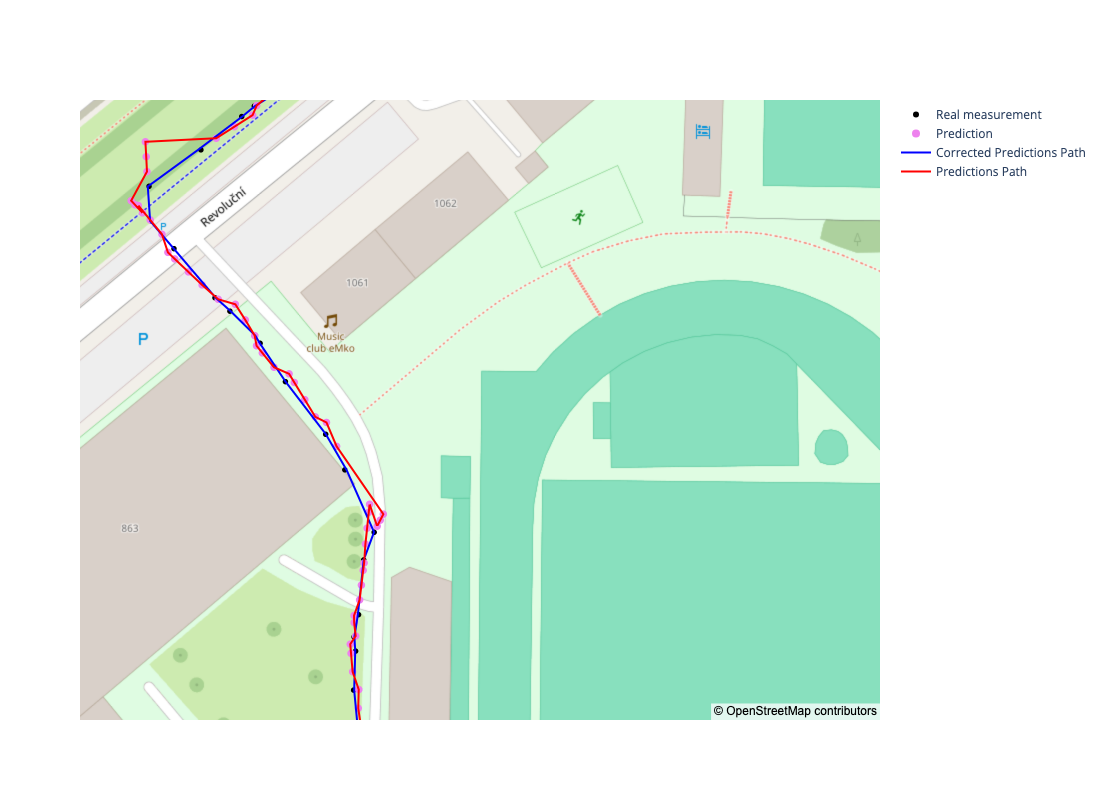

In [14]:
fig = go.Figure()

for i, real in enumerate(df):
    fig.add_trace(go.Scattermapbox(
        lon=[real[2]],
        lat=[real[1]], 
        marker=dict(size=6, color="black"),
        name="Real measurement",
        showlegend=False if i > 0 else True 
    ))

for i, pred in enumerate(x_est):
    fig.add_trace(go.Scattermapbox(
        lon=[pred[1]],
        lat=[pred[0]], 
        marker=dict(size=8, color="violet"),
        name="Prediction",
        showlegend=False if i > 0 else True 
    ))

fig.add_trace(go.Scattermapbox(
    lon=np.array(x_corr)[1:, 1],
    lat=np.array(x_corr)[1:, 0],
    mode='lines',
    line=dict(width=2, color="blue"),
    name="Corrected Predictions Path"
))

fig.add_trace(go.Scattermapbox(
    lon=np.array(x_est)[1:, 1],
    lat=np.array(x_est)[1:, 0],
    mode='lines',
    line=dict(width=2, color="red"),
    name="Predictions Path"
))

fig.update_layout(height=800, mapbox_style="open-street-map", mapbox_zoom=18, mapbox_center={"lat": np.mean(np.array(df)[:, 1]), "lon": np.mean(np.array(df)[:, 2])})
fig.show()

### Raw prediction vs real data difference

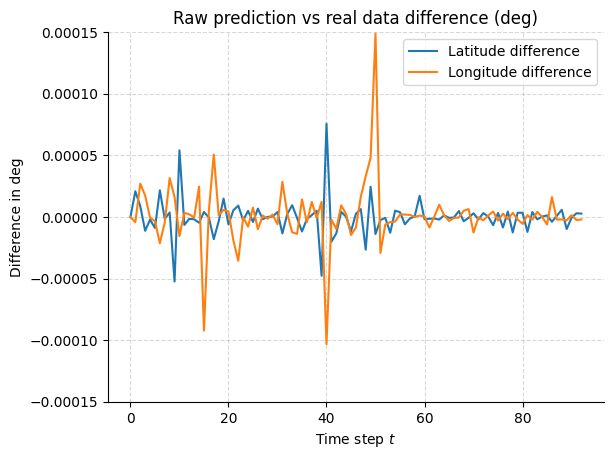

In [15]:
plt.figure(1)
ax = plt.gca()
ax.grid(color="grey", linestyle="--", alpha=0.3)
ax.set_ylim((-15e-5, 15e-5))
ax.plot(v, label=["Latitude difference", "Longitude difference"])
ax.set_xlabel(r'Time step $t$')
ax.set_ylabel('Difference in deg')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Raw prediction vs real data difference (deg)")

ax.legend()
plt.show()

In [16]:
vf = [calculate_distance(lat1, lon1, lat2, lon2) for (lat1, lon1), (lat2, lon2) in zip(np.array(x_corr)[:, :2], df[1:, 1:3])]

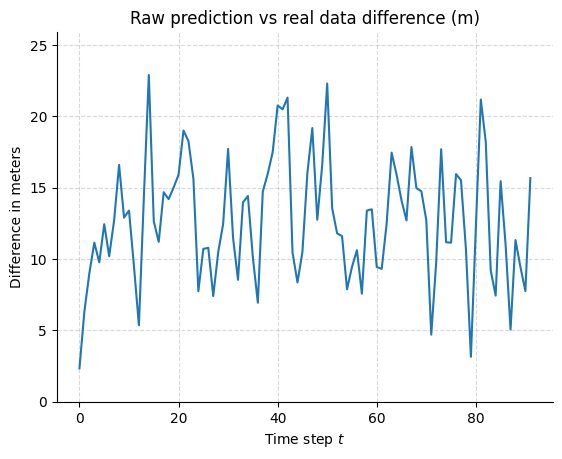

In [17]:
plt.figure(1)
ax = plt.gca()
ax.grid(color="grey", linestyle="--", alpha=0.3)
ax.set_ylim((0, np.max(vf) + 3))
ax.plot(vf)
ax.set_xlabel(r'Time step $t$')
ax.set_ylabel('Difference in meters')
plt.title("Raw prediction vs real data difference (m)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## THE END